In [92]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def get_RT_means_with_cutoff(data, groupby_cols, n_cutoff=2):
    mean = data.groupby(groupby_cols)['RT'].mean()
    # sem = data.groupby('tta_condition')[var].apply(lambda x: scipy.stats.sem(x, axis=None, ddof=0))
    n = data.groupby(groupby_cols).size()
    means = pd.DataFrame({'RT': mean, 'n': n}, index=mean.index)
    return means[means.n>n_cutoff].RT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
best_fit_params_path = '../model_fit_results/model_%i/best_fit_parameters/full_data_parameters_fitted.csv'
fit_results_path = '../model_fit_results/model_%i/simulation_results/full_data_measures.csv'

groupby_cols = ['subj_id', 'tta_condition', 'd_condition']

exp_measures = pd.read_csv('../data/measures.csv')
# exp_measures = exp_measures[~(exp_measures.subj_id==652)]
p_turn_by_condition = exp_measures.groupby(groupby_cols).mean().is_turn_decision
# rt_by_condition = exp_measures[exp_measures.is_turn_decision].groupby(groupby_cols).mean().RT
rt_by_condition = get_RT_means_with_cutoff(exp_measures[exp_measures.is_turn_decision], groupby_cols, n_cutoff=2)
data_means = pd.DataFrame([p_turn_by_condition, rt_by_condition]).T
print (len(data_means), len(p_turn_by_condition), len(rt_by_condition))

144 144 96


### Scatterplot of model predictions - experimental measures per participant per condition.

See how far from the y=x line the predictions are

In [4]:
def get_data_vs_model_means(model_no, data_means):
    model_measures = pd.read_csv(fit_results_path % model_no)
    model_measures = model_measures[model_measures.tta_condition.isin([4, 5, 6])
                                    & model_measures.d_condition.isin([90, 120, 150])
                                    & ~(model_measures.subj_id=='all')]
    model_measures['subj_id'] = pd.to_numeric(model_measures.subj_id)
    model_measures.set_index(groupby_cols, inplace=True)

    data_vs_model = data_means.join(model_measures, lsuffix='_data', rsuffix='_model').reset_index()
    data_vs_model = data_vs_model.rename(columns={'is_turn_decision_data': 'p_turn_data',
                                                  'is_turn_decision_model': 'p_turn_model'})
    data_vs_model['subj_id'] =  data_vs_model['subj_id'].astype(int)
    data_vs_model[['tta_condition', 'd_condition']] = data_vs_model[['tta_condition', 'd_condition']].astype(int)
    data_vs_model['condition'] = data_vs_model[['tta_condition', 'd_condition']].astype(str).agg('_'.join, axis=1).astype(str)

    return data_vs_model

In [5]:
def plot_data_vs_model(var, data_vs_model, model_no):
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(111)
    ax.axes.set_aspect('equal')
    g = sns.scatterplot(ax=ax, data=data_vs_model, x='%s_data' % var, y='%s_model' % var,
                        hue='subj_id', style='condition', legend='full', palette='tab20')
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2)
    control_x = np.linspace(data_vs_model.RT_data.min()-0.05, data_vs_model.RT_data.max()+0.05, 2) \
        if var=='RT' else np.linspace(0,1,2)
    ax.plot(control_x, control_x, color='grey')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    fit_metric = (1 - ((data_vs_model['%s_model' % var]-data_vs_model['%s_data' % var]).pow(2).sum())
                  /(data_vs_model['%s_data' % var]-data_vs_model['%s_data' % var].mean()).pow(2).sum())

    fig.suptitle(r'Model %i: not really $R^2=%.2f$' % (model_no, fit_metric))
    fig.savefig('../output/%s_%i.png' % (var, model_no), bbox_inches='tight')

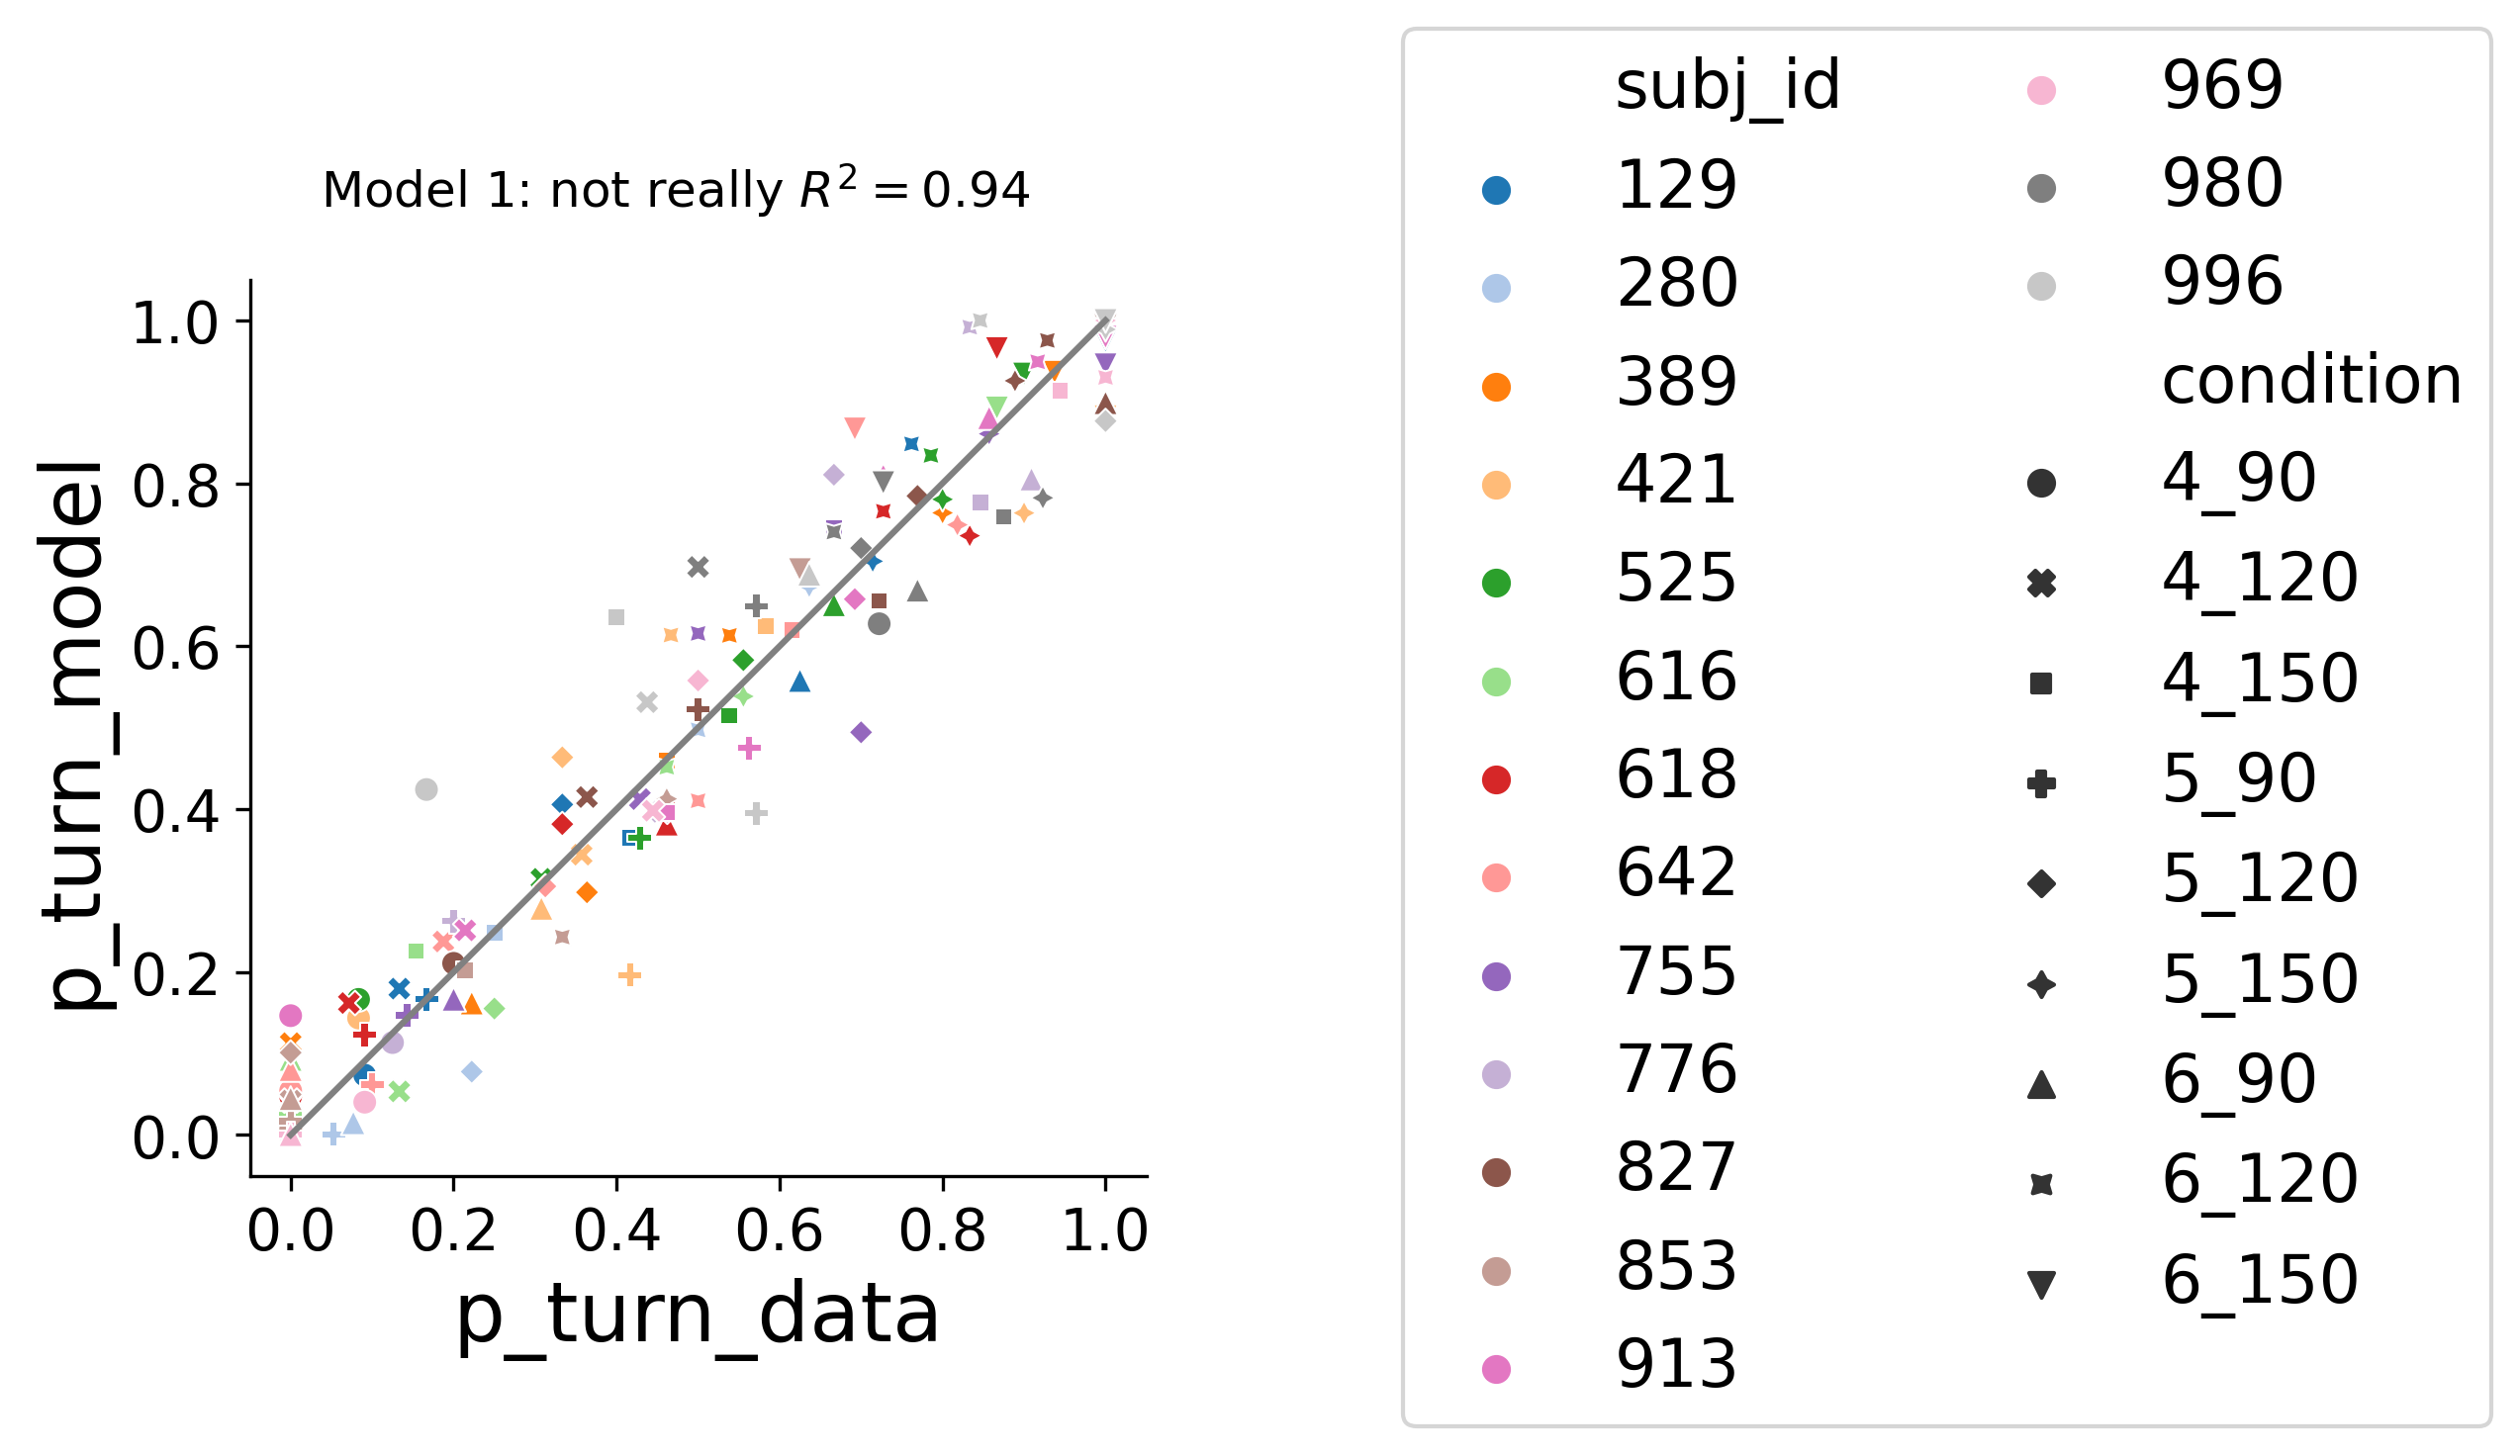

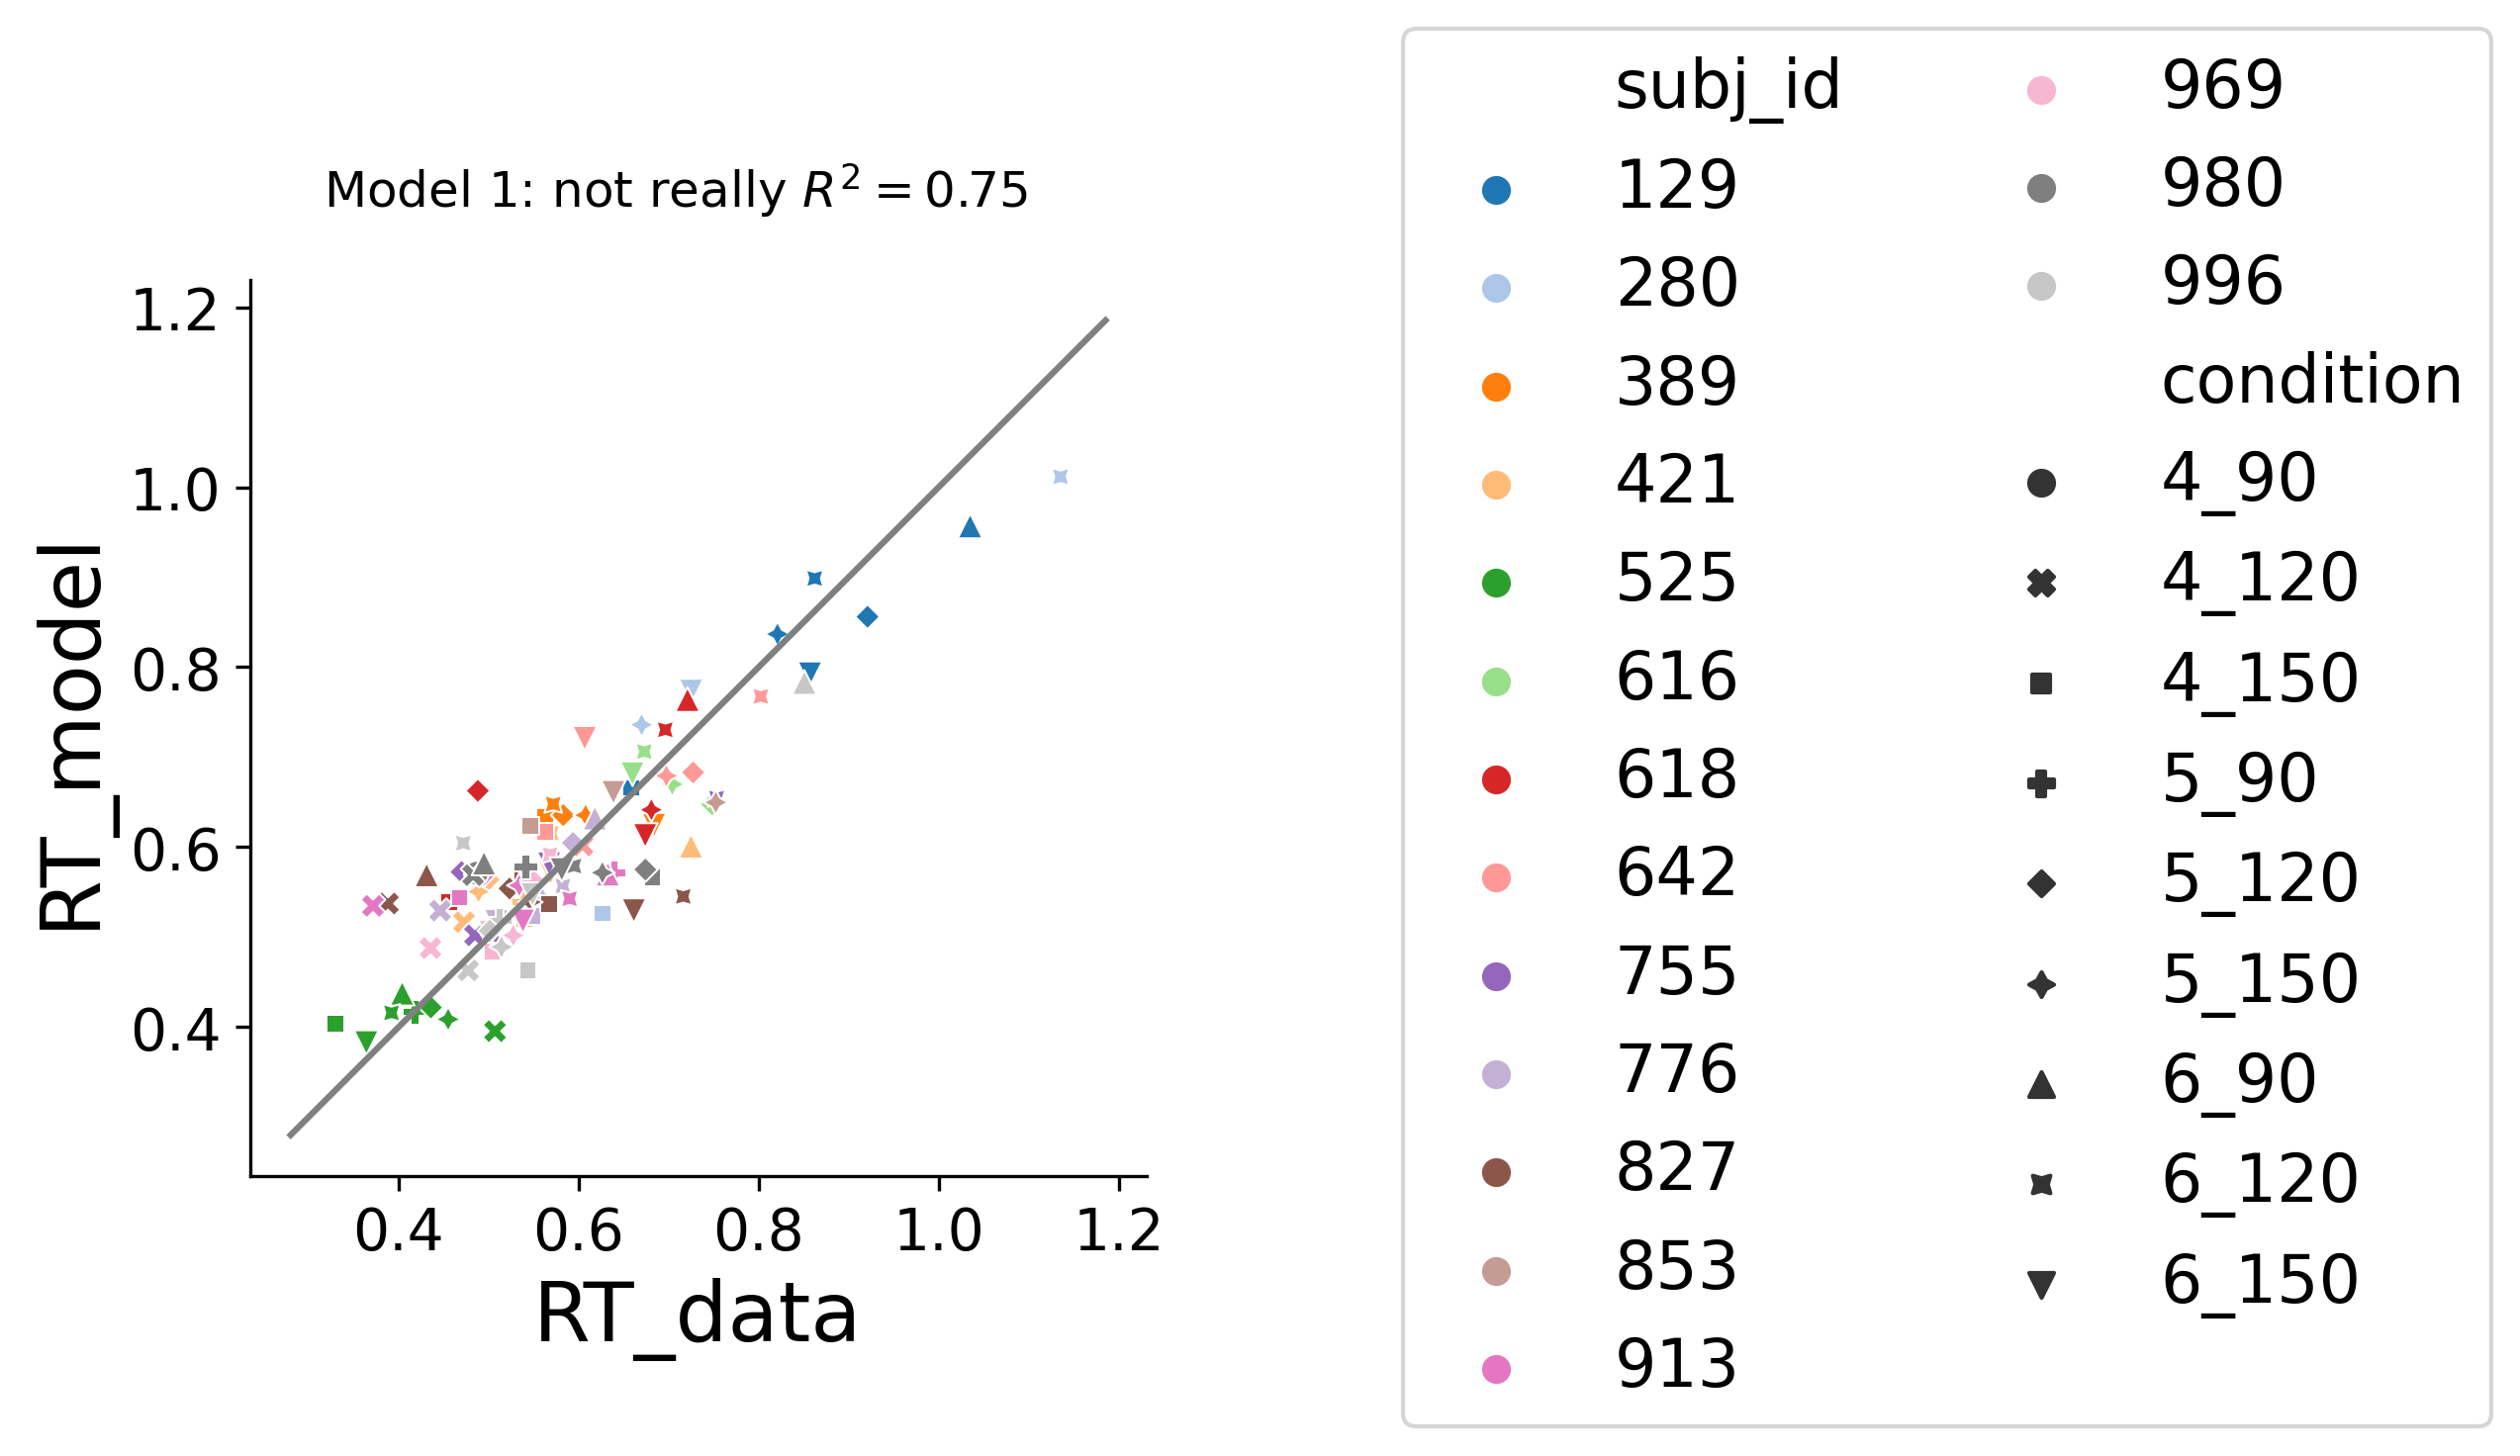

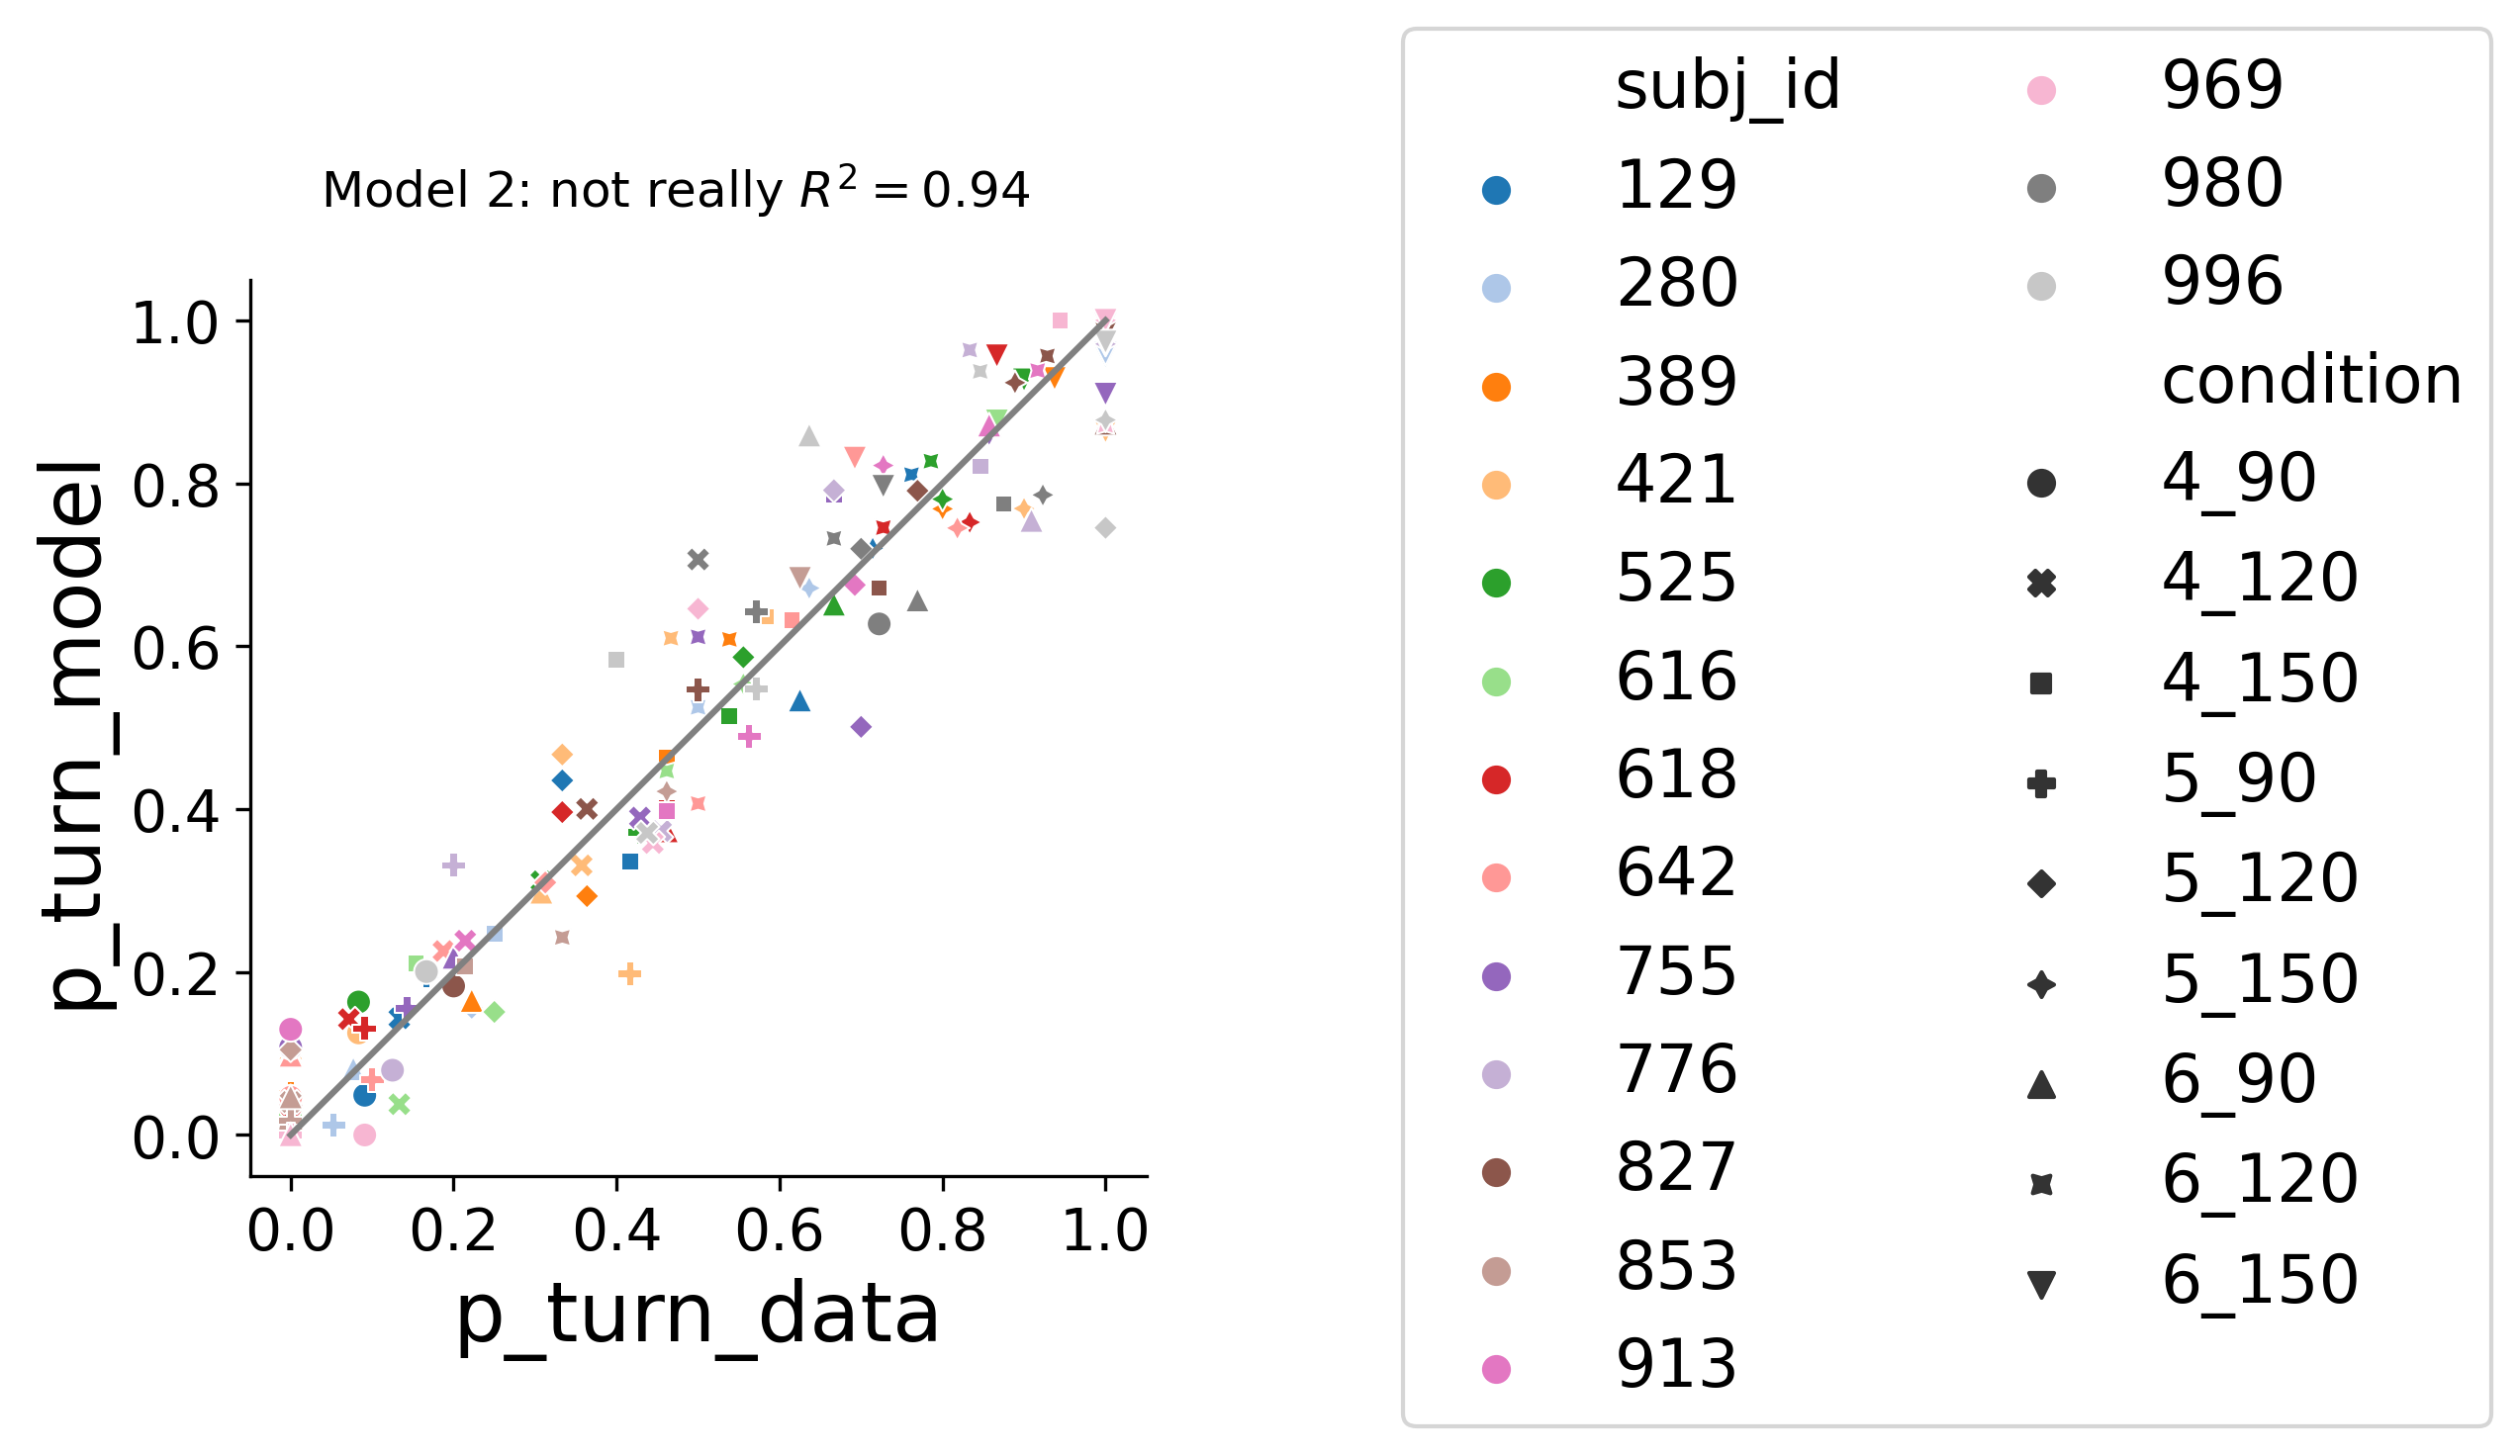

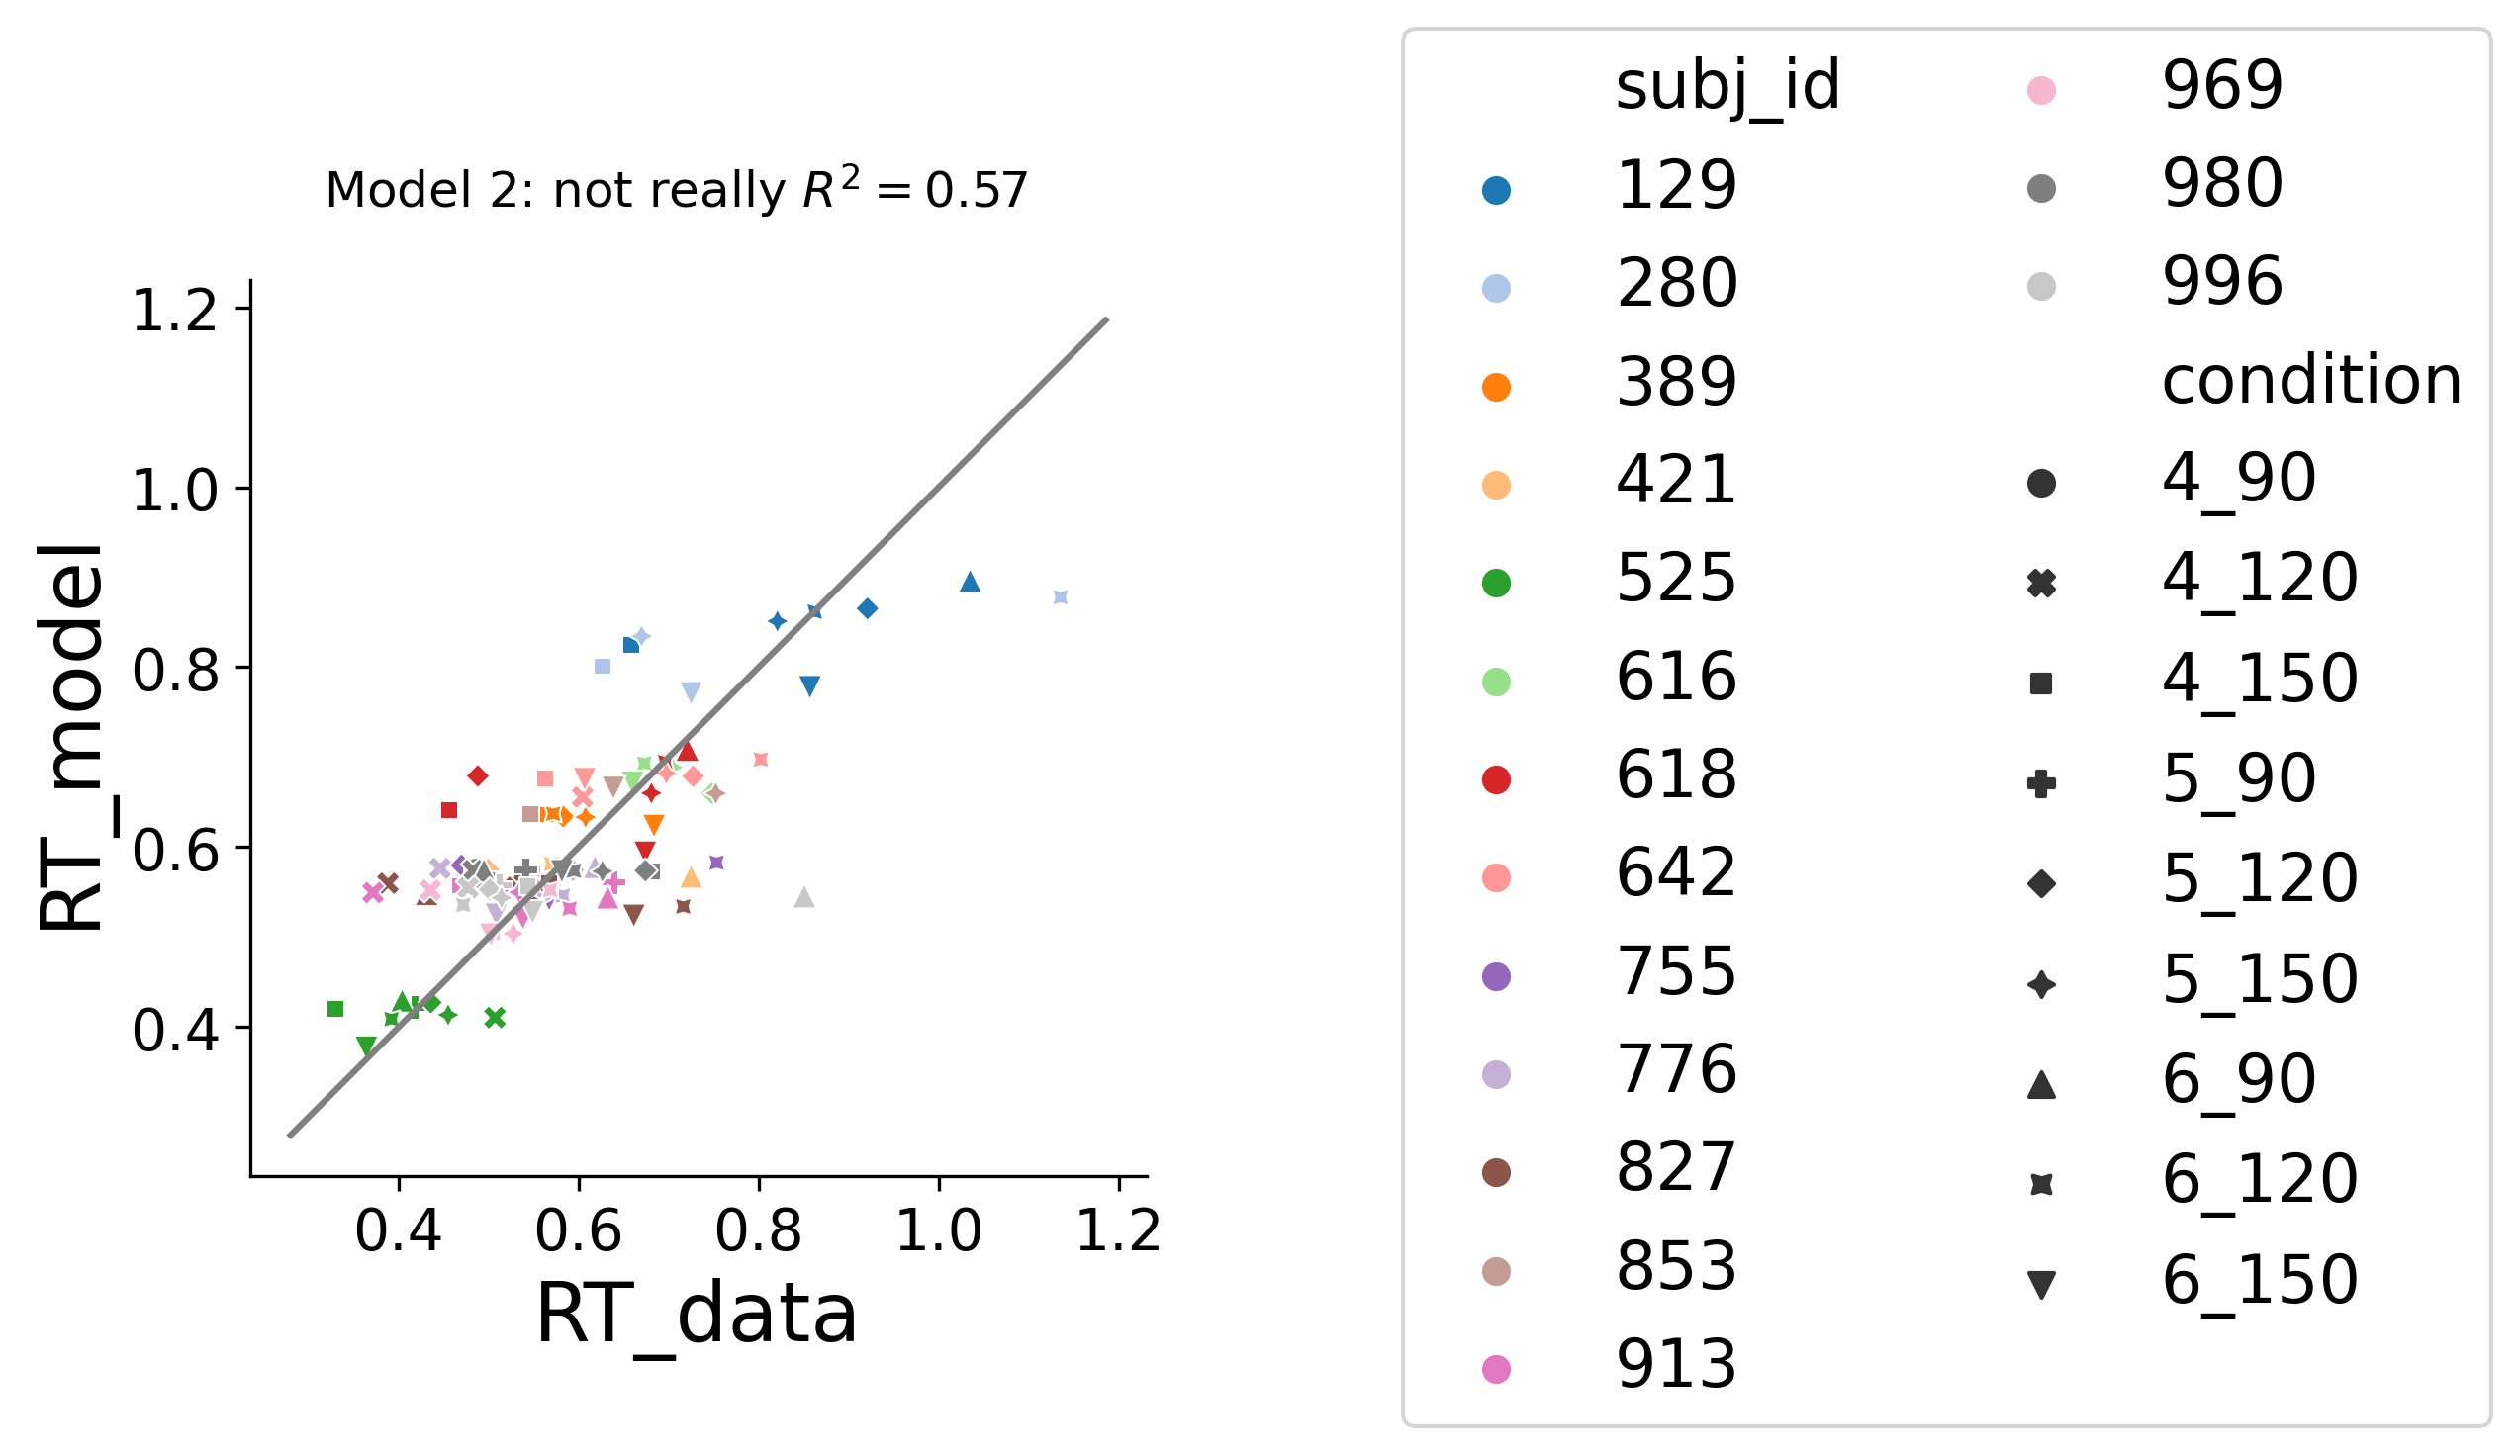

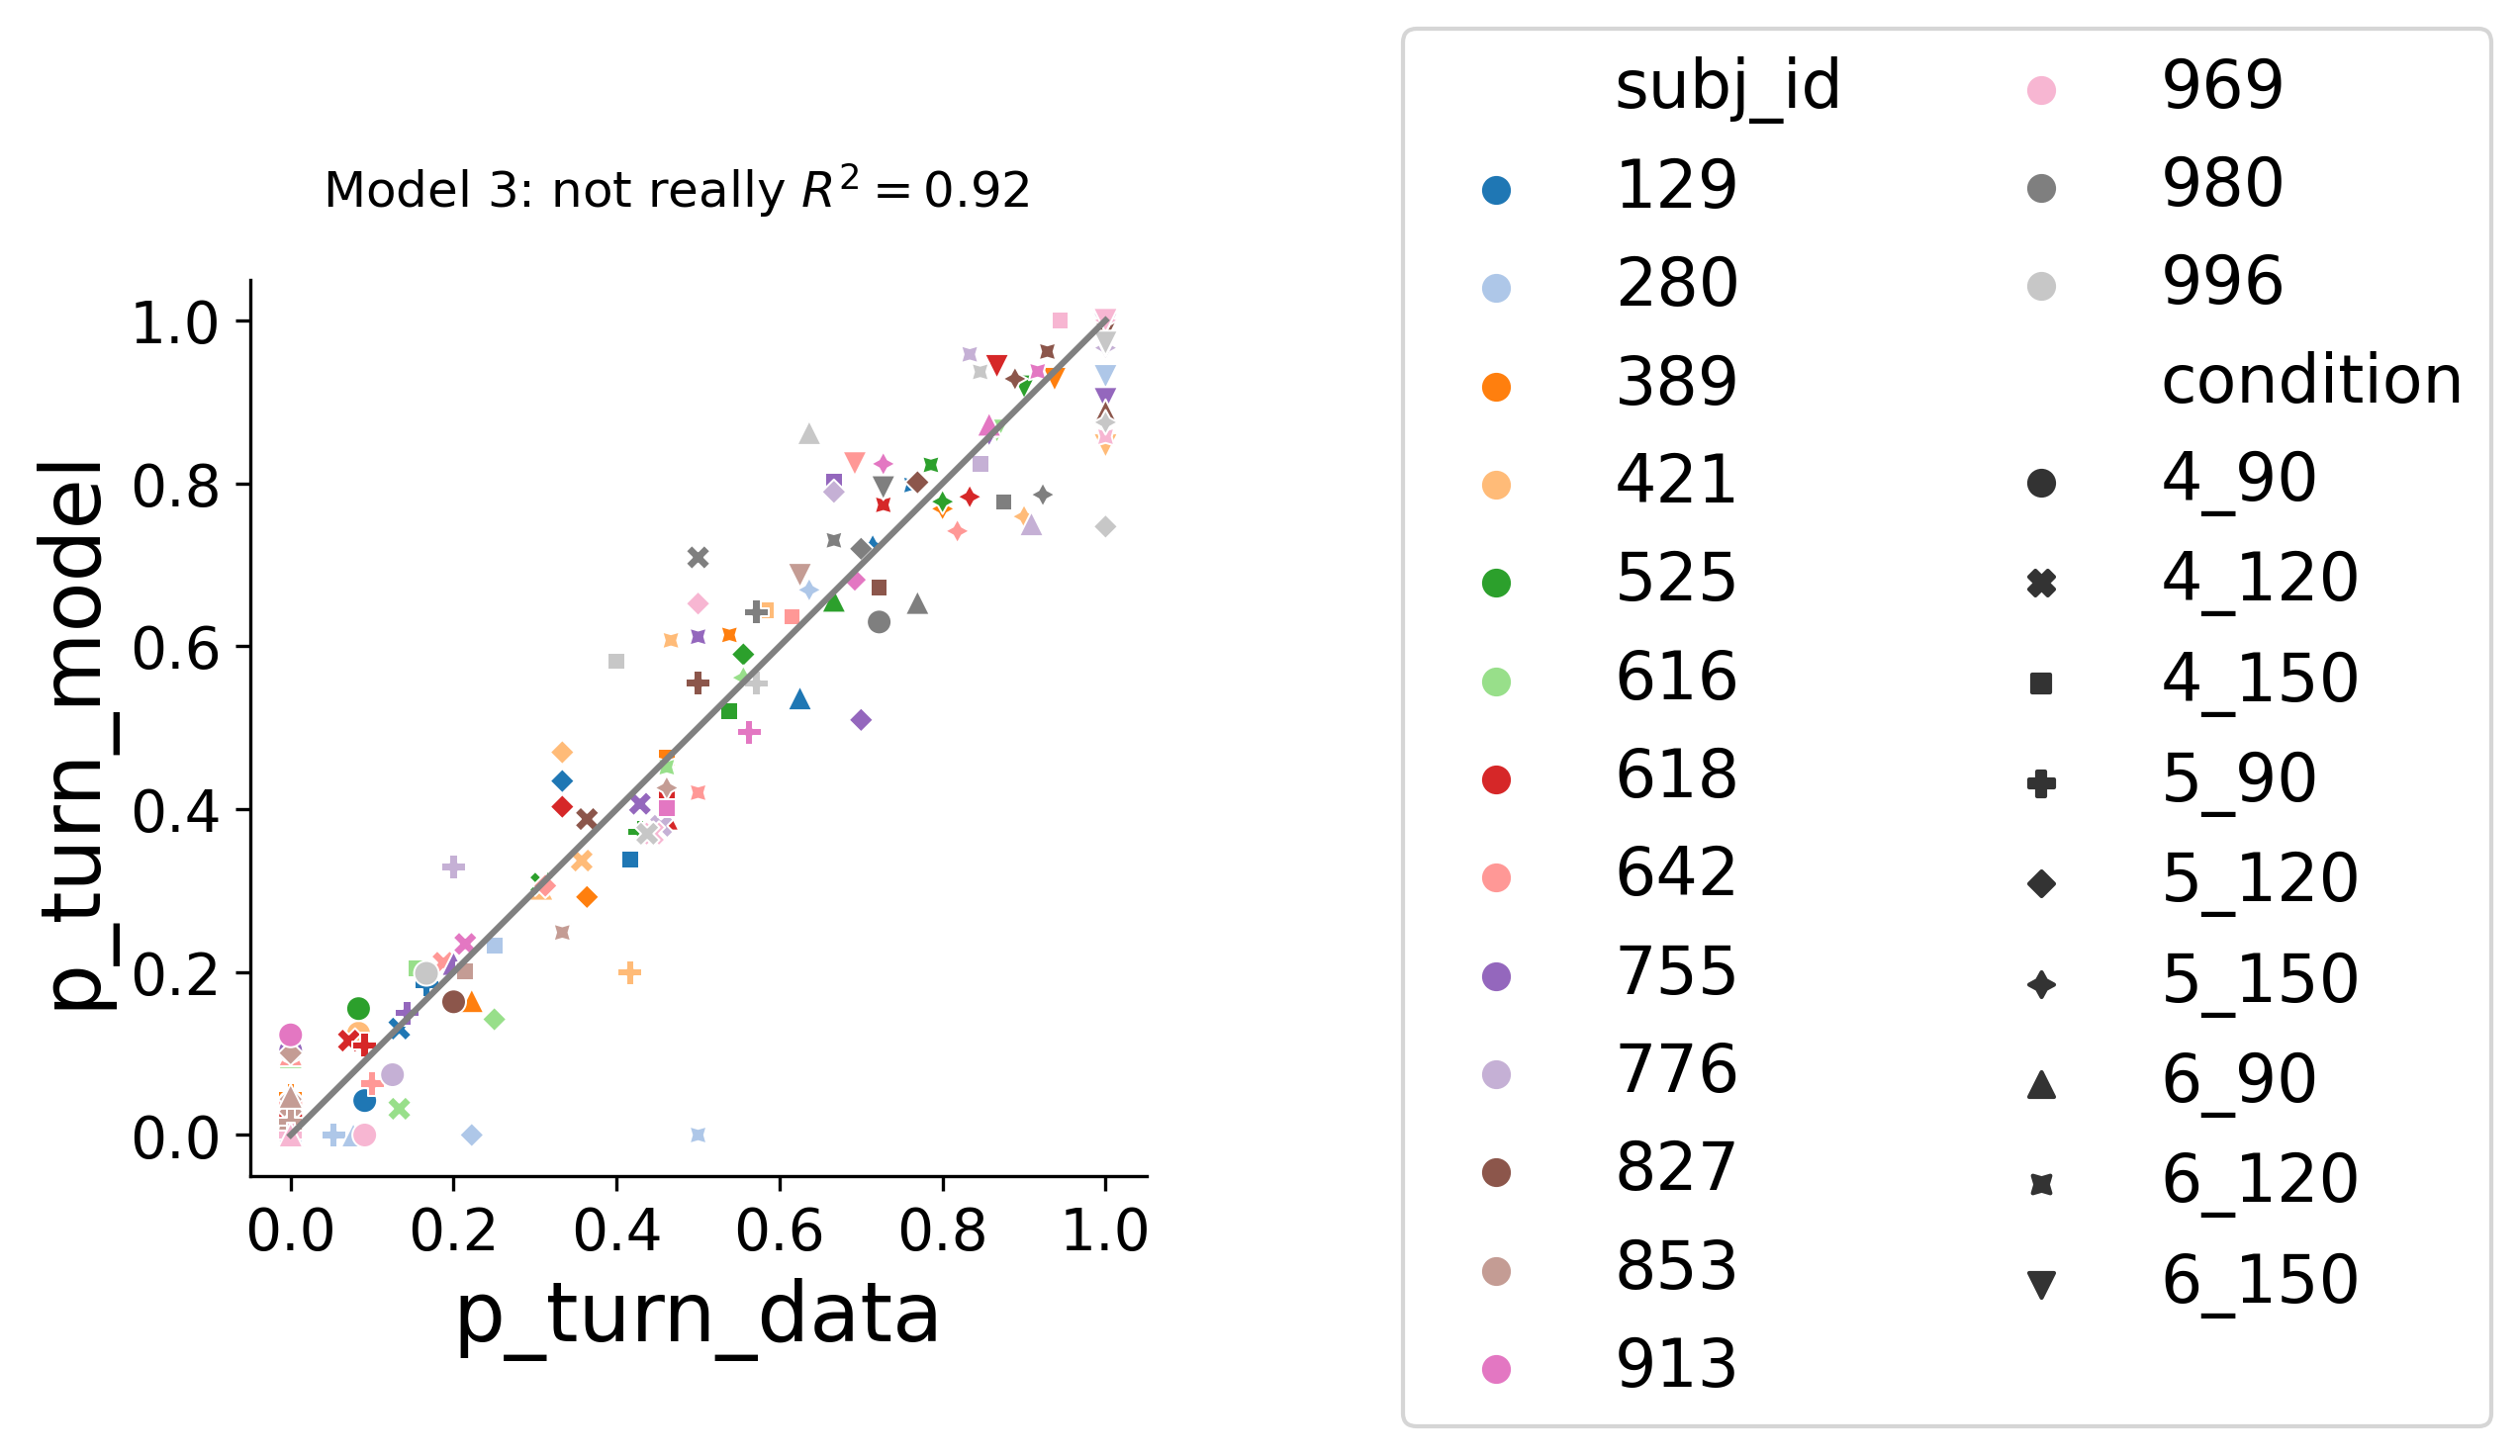

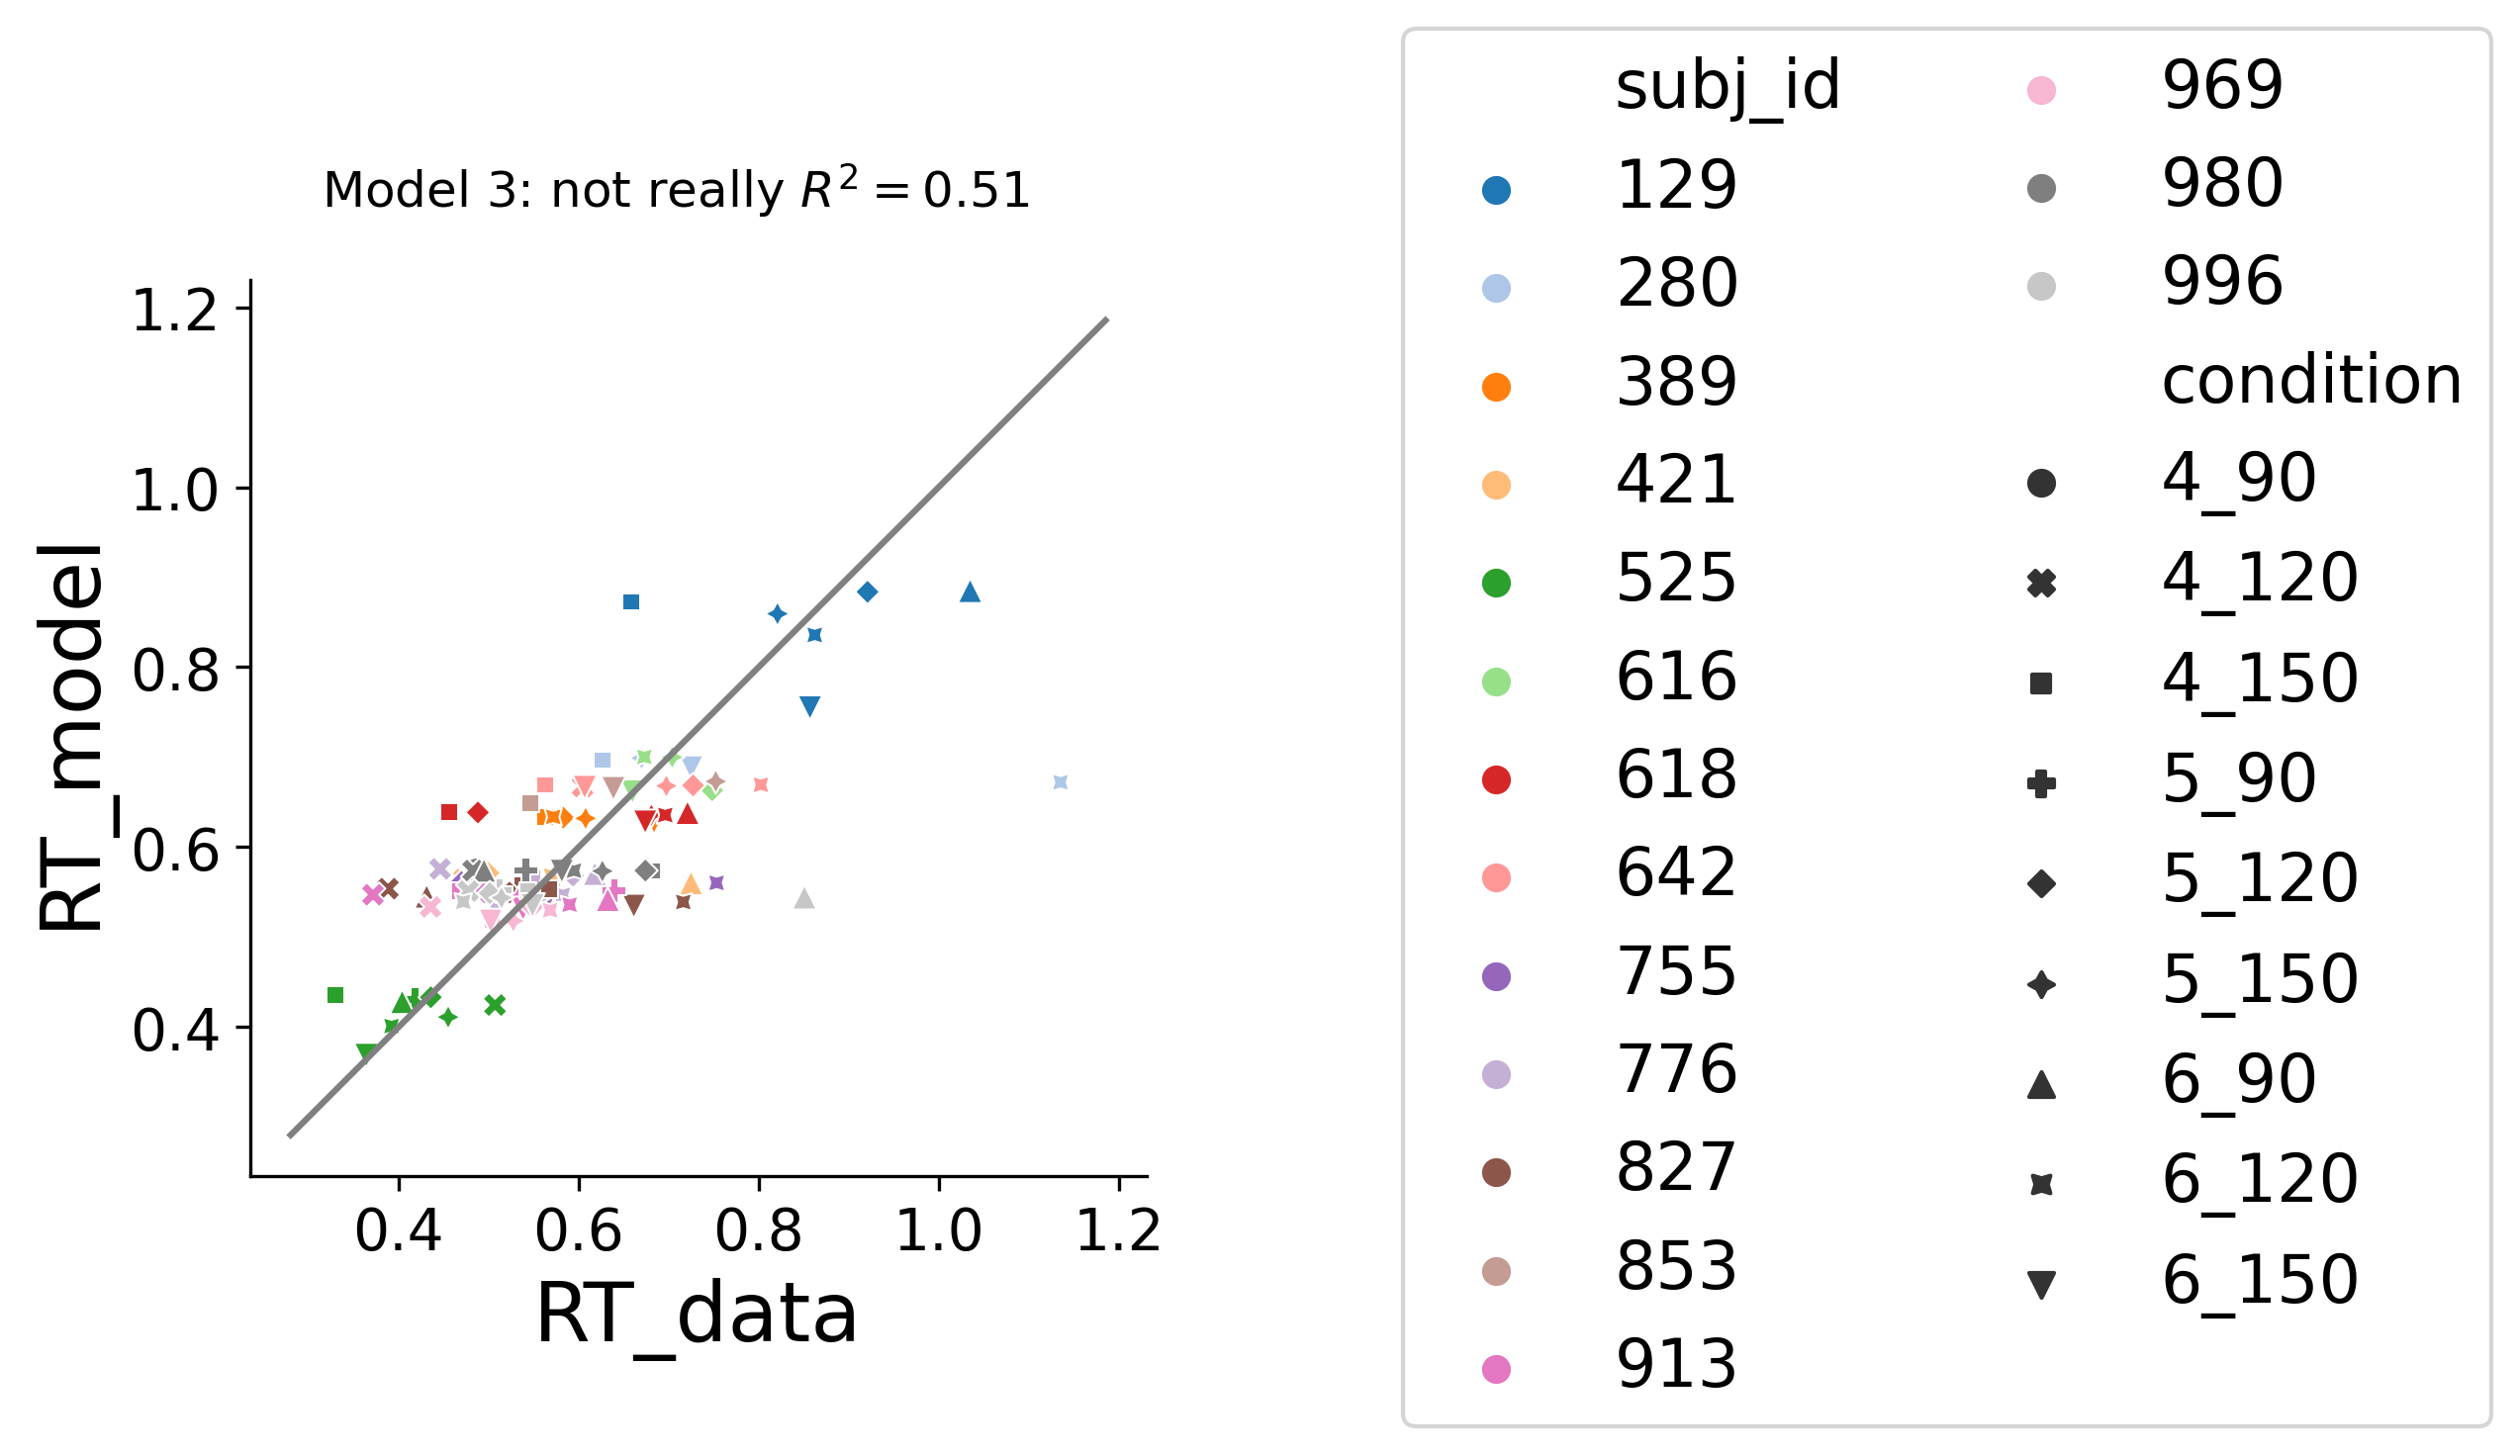

In [148]:
for model_no in [1,2,3]:
    data_vs_model = get_data_vs_model_means(model_no=model_no, data_means=data_means)
    plot_data_vs_model('p_turn', data_vs_model, model_no=model_no)
    plot_data_vs_model('RT', data_vs_model, model_no=model_no)

# ROC analysis attempt

The best theoretically possible ROC can be obtained from the estimated probabilities. By the way, the nudge-based manipulation of p_turn in the follow-up work could be linked to pushing the limits of theoretically possible prediction - if we cannot really be sure what the human will do and it might affect safety, we better sacrifice the current comfort to increase our prediction accuracy

In [131]:
np.linspace(1, 0, 21)

array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05, 0.  ])

In [132]:
def get_positive_rates(df, gamma):
    df["model_is_turn_decision"] = df["p_turn_model"]>gamma
    fpr = (len(df[~(df.is_turn_decision==df.model_is_turn_decision) & (df.model_is_turn_decision)])
                   /len(df[~df.is_turn_decision]))
    tpr = (len(df[(df.is_turn_decision==df.model_is_turn_decision) & (df.model_is_turn_decision)])
                   /len(df[df.is_turn_decision]))

    return (fpr, tpr)

def get_roc_curve(data_means, exp_measures, subj_id, model_no=1):
    subj_data_vs_model = exp_measures.loc[exp_measures.subj_id == subj_id,
                                          ["subj_id", "tta_condition", "d_condition", "is_turn_decision"]]
    if model_no == "best_case":
        model_predictions = data_means.reset_index().rename(columns={"is_turn_decision": "p_turn_model"})
    else:
        data_vs_model = get_data_vs_model_means(model_no=model_no, data_means=data_means)
        model_predictions = data_vs_model.loc[data_vs_model.subj_id == subj_id, 
                                              ["subj_id", "tta_condition", "d_condition", "p_turn_model"]]
    subj_data_vs_model = (subj_data_vs_model.merge(model_predictions, on=["subj_id", "tta_condition", "d_condition"])
                 .reset_index(drop=True))
    
    return np.array([get_positive_rates(subj_data_vs_model, gamma=gamma) for gamma in np.linspace(1.001, -0.001, 21)]).T

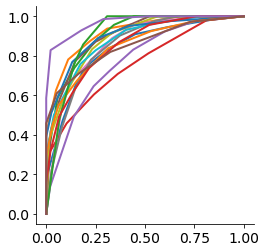

In [133]:
fig, ax = plt.subplots()
for subj_id in exp_measures.subj_id.unique():
    roc = get_roc_curve(data_means, exp_measures, subj_id, model_no="best_case")
    ax.plot(roc[0], roc[1])
ax.set_aspect("equal")

TODO: How to translate the plot below to the cross-validation results?

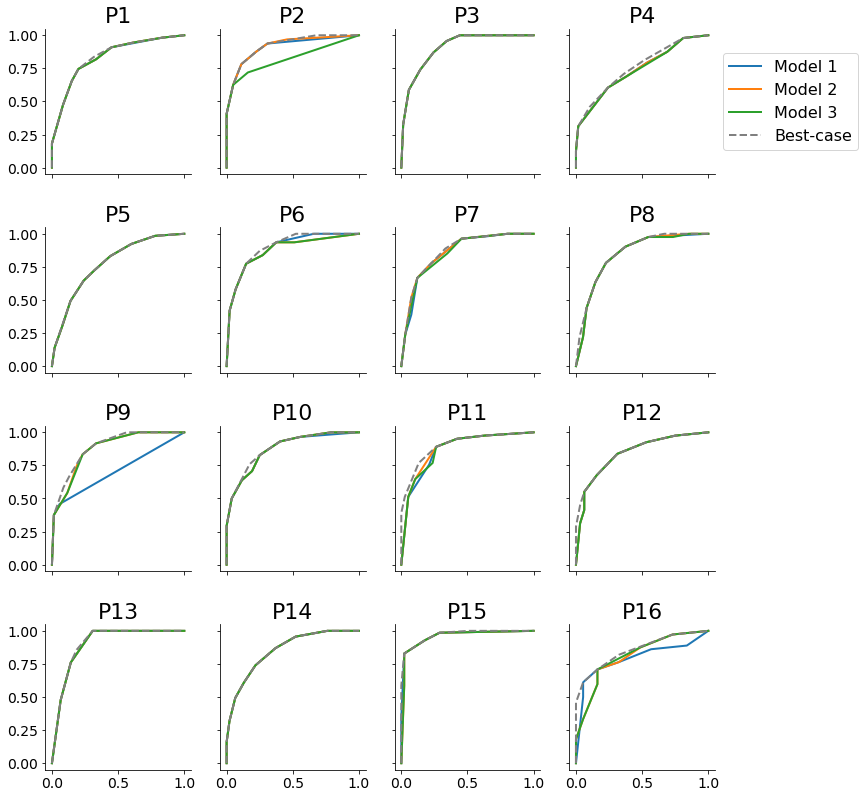

In [135]:
subjects = exp_measures.subj_id.unique()

fig, axes = plt.subplots(4, 4, figsize=(12,14), sharex=True, sharey=True)

for subj_id, subj_idx, ax in zip(subjects, range(len(subjects)), axes.flatten()):
    ax.set_aspect("equal")
    for model_no in [1, 2, 3]:
        model_roc = get_roc_curve(data_means, exp_measures, subj_id, model_no=model_no)
        ax.plot(model_roc[0], model_roc[1], label="Model %i" % model_no)
        
    best_case_roc = get_roc_curve(data_means, exp_measures, subj_id, model_no="best_case")
    ax.plot(best_case_roc[0], best_case_roc[1], label="Best-case", ls="--", color="grey")
    
    ax.set_title("P%i" % (subj_idx+1))
    if subj_idx == 3:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Catplot of parameter values per participant - see if any of the parameters tend to fall on the boundary of the parameter space

Todo